In [1]:
import os,sys
print(os.getcwd())
os.chdir())
print(os.getcwd())
# sys.path.append('..')
# from data_scripts.PI_CAI_Detection import PI_CAI_Detection

/u/home/ahy/adlm_ss2023_mmcl/notebooks


In [ ]:
import os, random, time, sys
# import imblearn
import skimage.data
import skimage.transform
import torch, torchvision
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np
import pandas as pd

import torch.optim as optim
import torch.nn as nn 
import torch.utils.data as data

from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision import transforms 
from PIL import Image
from collections import Counter
from datetime import datetime
sys.path.append('..')
from data_scripts.PI_CAI_Detection import PI_CAI_Detection

#from torchsummary import summary
from torchmetrics.classification import MulticlassCalibrationError
from torchmetrics.classification import BinaryCalibrationError
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix

In [14]:
%load_ext autoreload
%autoreload 2
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
DO_TRAINNING=True
TRAIN_TRAIN_EPOCHS=10
labels_path='/data1/practical-sose23/morphometric/picai_labels'
image_path='/data1/practical-sose23/morphometric/data'
modalities=["t2w"]
targetVoxelShape= (1.0, 1.0, 3.0) #(0.5, 0.5, 3.0)#(1,1,1) #EXP1: STUPID RESULTS
targetimageSize = [350, 350, 45]#(500,500,50)
multiModel=False
useAI_Segmentation=False
biasFeildCorrection=False
toShuffle = False
batchSize = 30

imageOutput_path= '/u/home/ahy/adlm_ss2023_mmcl/images'

## Loading Data

In [3]:
dataset = PI_CAI_Detection(image_path,labels_path,modalities,\
                            multiModel,useAI_Segmentation,biasFeildCorrection,\
                            targetVoxelShape,targetimageSize)
loader = DataLoader(dataset,batch_size=batchSize,shuffle=toShuffle,num_workers=4)

#### Visualizing the Data Distribution BEFORE fixing the Data Imbalance

In [5]:
# train_Lables=[]
# for _,_,batch_labels in loader:
#     train_Lables.extend(batch_labels)

train_Lables = dataset.get_Lables()

Original Training Data Distribution
minorty_class=1,	minorty_count=220
majorty_class=0,	majorty_count=1075
Image stored at: /u/home/ahy/adlm_ss2023_mmcl/images/Original_Data_Distribution.png
2023-06-02, 11:40:49 Data Distr. Plotted


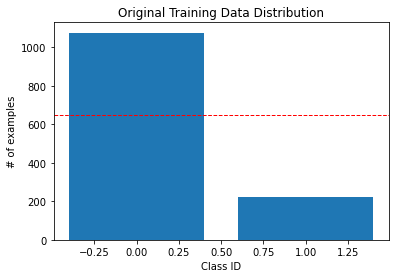

In [8]:
counter_train_original = Counter(train_Lables)
dataset_minorty_class,dataset_minorty_count = counter_train_original.most_common()[-1]  # least common
dataset_majorty_class,dataset_majorty_count = counter_train_original.most_common()[0]   # most  common
print("Original Training Data Distribution")
print(f'minorty_class={dataset_minorty_class},\tminorty_count={dataset_minorty_count}')
print(f'majorty_class={dataset_majorty_class},\tmajorty_count={dataset_majorty_count}')

plt.bar(counter_train_original.keys(), counter_train_original.values())
plt.axhline(np.mean(list(counter_train_original.values())), color='red', linestyle='dashed', linewidth=1)
plt.title("Original Training Data Distribution")
plt.xlabel("Class ID")
plt.ylabel("# of examples")

imagename = str("%s/Original_Data_Distribution.png"%(imageOutput_path))
plt.savefig(imagename, bbox_inches = 'tight', pad_inches=0.5)
print("Image stored at: %s"%imagename)

now = datetime.now() # current date and time
print(now.strftime("%Y-%m-%d, %H:%M:%S"),"Data Distr. Plotted")

## WeightedRandomSampler to solve the data Imbalance
using weights as probabilities to sample more from the minority class than the majority class

In [9]:
# Code ref: https://discuss.pytorch.org/t/how-to-handle-imbalanced-classes/11264/2

# Compute samples weight (each sample should get its own weight)
class_sample_count = np.unique(train_Lables, return_counts=True)[1]
weight = 1. / class_sample_count
samples_weight = weight[train_Lables]
WeightedRandomSampler = data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight))

In [10]:
loader_WeightedRandomSampler = DataLoader(dataset, batch_size=batchSize,
                          shuffle=toShuffle, sampler=WeightedRandomSampler, num_workers=4)

# Based on :  https://discuss.pytorch.org/t/apply-weightedrandomsampler-to-validation-test-splits-makes-sense/93733/2
# it makes sense to only adjust the trainning split and ignore both validation and testing set. 
# Thus we train on different data, but we use same validation and testing sets as before.

# loader_val_WeightedRandomSampler = data.DataLoader(val_data, batch_size=BATCH_SIZE,
#                         shuffle=False, sampler=WeightedRandomSampler, num_workers=4)

In [11]:
train_weighted_Lables=[]
for _,_,batch_labels in loader_WeightedRandomSampler:
    train_weighted_Lables.extend(batch_labels)

/u/home/ahy/.conda/envs/morph_2/lib/python3.9/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/u/home/ahy/.conda/envs/morph_2/lib/python3.9/site-packages/monai/data/__init__.py:120: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  t = cls([], dtype=storage.dtype, device=storage.device)
/u/home/ahy/.conda/envs/morph_2/lib/python3.9/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedSto

#### Visualizing the Data Distribution AFTER fixing the Data Imbalance

Weighted Random Sampler Training Data Distribution
minorty_class=1,	minorty_count=639
majorty_class=0,	majorty_count=656
Image stored at: /u/home/ahy/adlm_ss2023_mmcl/images/OriginalVsRandomWeighted_train_Data_distribution.png
2023-06-02, 12:07:46 Original Vs RandomWeighted Data distribution Plotted


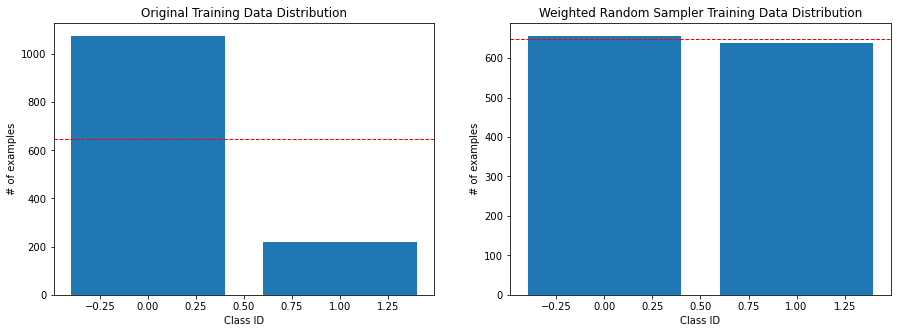

In [15]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))
counter_train_WeightedRandomSampler = Counter([i.item() for i in train_weighted_Lables])
dataset_minorty_class,dataset_minorty_count = counter_train_WeightedRandomSampler.most_common()[-1]  # least common
dataset_majorty_class,dataset_majorty_count = counter_train_WeightedRandomSampler.most_common()[0]   # most  common
print("Weighted Random Sampler Training Data Distribution")
print(f'minorty_class={dataset_minorty_class},\tminorty_count={dataset_minorty_count}')
print(f'majorty_class={dataset_majorty_class},\tmajorty_count={dataset_majorty_count}')

axs[0].bar(counter_train_original.keys(), counter_train_original.values())
axs[0].axhline(np.mean(list(counter_train_original.values())), color='red', linestyle='dashed', linewidth=1)
axs[0].set_title("Original Training Data Distribution")
axs[0].set_xlabel("Class ID")
axs[0].set_ylabel("# of examples")


axs[1].bar(counter_train_WeightedRandomSampler.keys(), counter_train_WeightedRandomSampler.values())
axs[1].axhline(np.mean(list(counter_train_WeightedRandomSampler.values())), color='red', linestyle='dashed', linewidth=1)
axs[1].set_title("Weighted Random Sampler Training Data Distribution")
axs[1].set_xlabel("Class ID")
axs[1].set_ylabel("# of examples")

# save plot
imagename = str("%s/OriginalVsRandomWeighted_train_Data_distribution.png"%(imageOutput_path))
plt.savefig(imagename, bbox_inches = 'tight', pad_inches=0.5)
print("Image stored at: %s"%imagename)

now = datetime.now() # current date and time
print(now.strftime("%Y-%m-%d, %H:%M:%S"),"Original Vs RandomWeighted Data distribution Plotted")

In [13]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB') 

True
1
0
Using device: cuda

NVIDIA A40
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [ ]:

generator1 = torch.Generator().manual_seed(42)
train, val, test = utils.data.random_split(dataset, [0.6, 0.2, 0.2], generator=generator1)
train_loader = DataLoader(train,batch_size=batchSize,shuffle=toShuffle, num_workers=4)#, sampler=WeightedRandomSampler)
val_loader = DataLoader(val,batch_size=batchSize,shuffle=toShuffle, num_workers=4)
test_loader = DataLoader(test,batch_size=batchSize,shuffle=toShuffle, num_workers=4)


In [ ]:
def plot(img):
    pixel_array = img.numpy()    
    # pixel_array.premute()
    
    columns = 5
    rows = math.ceil(pixel_array.shape[0] / columns)
    fig = plt.figure(figsize=(50,rows*10))

    for i in range(pixel_array.shape[0]):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(pixel_array[i], cmap="gray", interpolation="none")


In [ ]:
import monai
from monai.networks.nets import resnet10, resnet18, resnet50
model = resnet10(pretrained=False, n_input_channels = 1, num_classes = 1)


## Create some Model

In [68]:
import lightning.pytorch as pl
# define any number of nn.Modules (or use your current ones)
encoder = nn.Sequential(
    nn.Conv3d(1, 10, 3, padding = 1), 
    nn.ReLU(), 
    nn.MaxPool3d(2), 
    nn.Conv3d(10, 20, 3, padding = 1), 
    nn.ReLU(), 
    nn.MaxPool3d(2),
    nn.Conv3d(20, 20, 3, padding = 1), 
    nn.ReLU(), 
    nn.MaxPool3d(2),
    )
classifier = nn.Sequential(nn.Linear(184900, 5), nn.ReLU(), nn.Linear(5, 1), nn.Sigmoid())


# define the LightningModule
class Simple_Classifier(pl.LightningModule):
    def __init__(self, encoder, classif, loss=nn.BCELoss()):
        super().__init__()
        self.encoder = encoder
        self.classif = classif
        self.loss = loss
        self.image = image
        self.target = target

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        x = torch.unsqueeze(x,1)
        z = self.encoder(x)
        z = z.view(z.size(0), -1)
        x_hat = self.classif(z).squeeze(0)

        loss = self.loss(x_hat, y)
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


# init the autoencoder
classifier_model = Simple_Classifier(encoder, classifier)

ModuleNotFoundError: No module named 'lightning'

## Train Data Balanced UniModal Model

In [ ]:
trainer.fit(model=classifier_model, train_dataloaders=loader_WeightedRandomSampler)

## trainning without PL Lightning , work in progress

In [ ]:
if DO_TRAINNING:
    # List to save training and val loss and accuracies
    train_loss_list = [0]*TRAIN_EPOCHS
    train_acc_list = [0]*TRAIN_EPOCHS
    val_loss_list = [0]*TRAIN_EPOCHS
    val_acc_list = [0]*TRAIN_EPOCHS

    for epoch in range(TRAIN_EPOCHS):
        print("Epoch-%d: " % (epoch))

        train_start_time = time.monotonic()
        train_loss, train_acc = train(model, trainloader, optimizer, criterion)
        train_end_time = time.monotonic()

        val_start_time = time.monotonic()
        val_loss, val_acc = evaluate(model, valloader, optimizer, criterion)
        val_end_time = time.monotonic()

        train_loss_list[epoch] = train_loss
        train_acc_list[epoch] = train_acc
        val_loss_list[epoch] = val_loss
        val_acc_list[epoch] = val_acc

        print("Training: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (train_loss, train_acc, train_end_time - train_start_time))
        print("Validation: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (val_loss, val_acc, val_end_time - val_start_time))
        print("")

    now = datetime.now() # current date and time
    print(now.strftime("%Y-%m-%d, %H:%M:%S"),"Model trained")
else:
    print("skipped here")